In [ ]:
import os
import time
import copy
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, average_precision_score, log_loss, brier_score_loss

from utils_data import split_dataset
from utils_metrics import brier_loss, plot_confusion_matrix, plot_precision_recall_curve, evaluate_model

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# Split if output folders don't exist already
if not Path("brain_tumor_dataset/train").exists():
    split_dataset("brain_tumor_dataset", train_ratio=0.7, val_ratio=0.15, image_ext="*.jpg")

Category 'no': 63 train, 13 val, 15 calibration
Category 'yes': 107 train, 23 val, 24 calibration
Dataset successfully split into training, validation, and calibration sets.


In [4]:
data_dir = 'brain_tumor_dataset'

# Data augmentation for train; only normalization for val & calibration
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'calibration': transforms.Compose([  # Same as val, no augmentation
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets including calibration
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'calibration']}

# Create dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True if x == 'train' else False, num_workers=4)
              for x in ['train', 'val', 'calibration']}

# Get dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'calibration']}

# Class names
class_names = image_datasets['train'].classes
class_names

['no', 'yes']

In [5]:
model = models.vgg16(pretrained=True)

# Freeze all the parameters
# for param in model.parameters():
#     param.requires_grad = False

# Freeze feature extractor
for param in model.features.parameters():
    param.requires_grad = False  

# Train classifier
for param in model.classifier.parameters():
    param.requires_grad = True  

# Modify the classifier
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)  # Assuming binary classification
# model.classifier[3] = nn.Linear(4096, 256)
# model.classifier[6] = nn.Linear(256, 2)


model = model.to(device)
# model

c:\Users\AsusTUF\anaconda3\envs\tru_image_cancer_prediction\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\AsusTUF\anaconda3\envs\tru_image_cancer_prediction\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
model.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [7]:
criterion = nn.CrossEntropyLoss()

LAYERS = model.classifier[6]
LEARNING_RATE = 0.001

# Only parameters of the final layer are being optimized
# optimizer = optim.SGD(model.classifier[6].parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(LAYERS.parameters(), lr=LEARNING_RATE)

LAYERS

Linear(in_features=4096, out_features=2, bias=True)

In [8]:
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, device, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0  # Track best F1-score

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Store labels and predictions for F1-score
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Compute F1-score
            epoch_f1 = f1_score(all_labels, all_preds, average='macro')

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')

            # Save model if it has the best F1-score
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val F1: {best_f1:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [9]:
model = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, device, num_epochs=5) # num_epochs=25 

Epoch 0/4
----------
train Loss: 0.6511 Acc: 0.6176 F1: 0.5312
val Loss: 0.4283 Acc: 0.8333 F1: 0.8125

Epoch 1/4
----------
train Loss: 0.5652 Acc: 0.7000 F1: 0.6703
val Loss: 0.3599 Acc: 0.8333 F1: 0.8194

Epoch 2/4
----------
train Loss: 0.4889 Acc: 0.7706 F1: 0.7032
val Loss: 0.3389 Acc: 0.8611 F1: 0.8519

Epoch 3/4
----------
train Loss: 0.4229 Acc: 0.8059 F1: 0.7913
val Loss: 0.4804 Acc: 0.7500 F1: 0.7498

Epoch 4/4
----------
train Loss: 0.4743 Acc: 0.7824 F1: 0.7758
val Loss: 0.3084 Acc: 0.8333 F1: 0.8194

Training complete in 3m 1s
Best val F1: 0.8519


In [10]:
for inputs, labels in dataloaders['val']:
    y_pred = model(inputs)
y_pred 

tensor([[-0.1396,  0.3028],
        [-1.7344,  2.4078],
        [-0.1621,  0.5215],
        [-1.1161,  1.9425]], grad_fn=<AddmmBackward0>)

In [11]:
from PIL import Image

model.eval()
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Ensure it's RGB
    image = transform(image)  # Apply transformations
    image = image.unsqueeze(0)  # Add batch dimension (1, C, H, W)
    return image


def predict(image_path, model, class_names, device):
    image = preprocess_image(image_path).to(device)  # Send image to device (GPU/CPU)
    
    # Perform inference
    model.eval()  # Ensure model is in eval mode
    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, 1)  # Get the class index

    return class_names[predicted_class.item()]  # Return class label

# Define class names based on training data
class_names = ["no", "yes"]  # Modify based on your dataset structure

# # Path to a sample MRI image
# sample_image = "brain_tumor_dataset/val/yes/Y8.jpg"  # Replace with an actual image path

# # Run inference
# predicted_label = predict(sample_image, model, class_names, device)
# print(f"Predicted Label: {predicted_label}")


In [12]:
import torch
import torch.nn.functional as F

def predict_proba(model, dataloader, device):
    all_probs = []
    all_labels = []

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculations
        for inputs, labels in dataloader:
            inputs = inputs.to(device)  # Move input to GPU/CPU
            outputs = model(inputs)  # Get raw model outputs (logits)

            # Apply Softmax if using CrossEntropyLoss (multi-class)
            probs = F.softmax(outputs, dim=1)[:, 1]  # Extract probability of positive class (index 1)

            all_probs.append(probs.cpu())  # Move to CPU and store
            all_labels.append(labels.cpu())


    return torch.cat(all_labels), torch.cat(all_probs)  # Concatenate all probabilities into a single tensor

# Run inference on validation dataset
val_labels, val_probs = predict_proba(model, dataloaders['val'], device)
cal_labels, cal_probs = predict_proba(model, dataloaders['calibration'], device)


# Print shape of output tensor
print(val_probs.shape)  # Should match number of validation samples
print("validation labels:")
print(val_labels)
print("validation probs:")
print(val_probs)  # Display tensor of probabilities


torch.Size([36])
validation labels:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
validation probs:
tensor([0.2580, 0.0889, 0.2636, 0.1540, 0.7035, 0.0315, 0.2571, 0.4951, 0.6104,
        0.2046, 0.1062, 0.4824, 0.0661, 0.9756, 0.3654, 0.9585, 0.9632, 0.8234,
        0.9419, 0.6686, 0.9149, 0.8747, 0.8879, 0.5631, 0.9626, 0.5963, 0.9229,
        0.2966, 0.9185, 0.4070, 0.8659, 0.6269, 0.6088, 0.9844, 0.6645, 0.9552])


# Base Model Evaluation
Accuracy: 0.8611111111111112
F1 Score: 0.8888888888888888
Average Precision Score: 0.9597817142126603


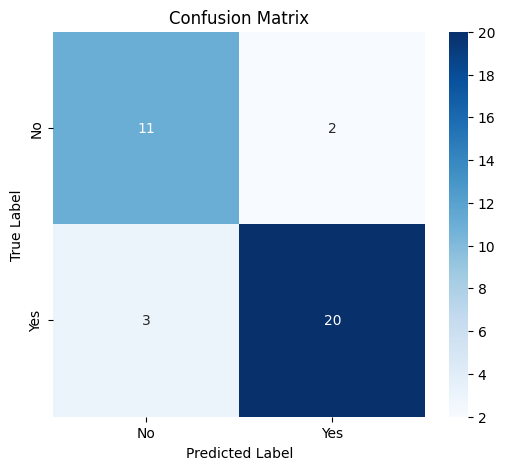

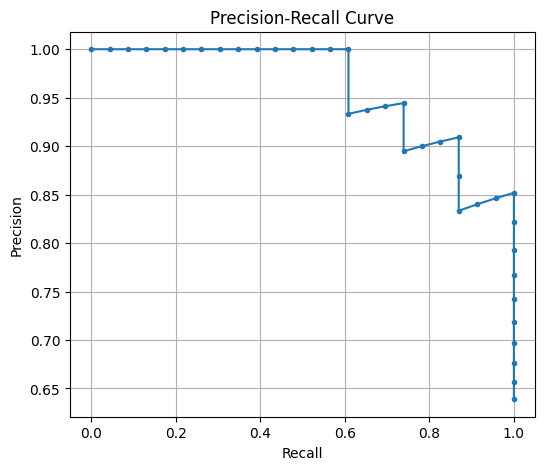


# Calibration Evaluation
Log Loss: 0.3388933950813706
Brier Loss: 0.1073108332857961


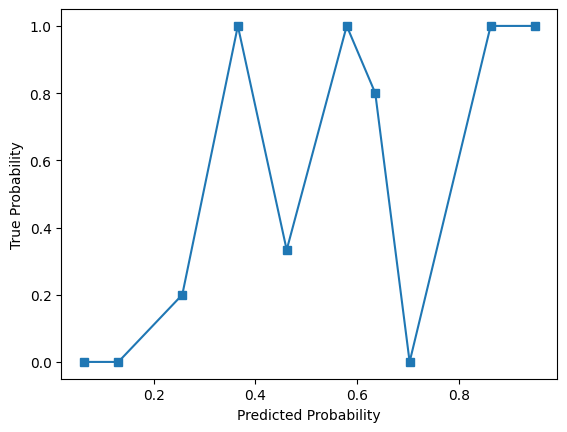

In [13]:
evaluate_model(val_labels, val_probs)

In [15]:
# Fit logistic regression for Platt Scaling
platt_scaler = LogisticRegression()
platt_scaler.fit(cal_probs.reshape(-1, 1), cal_labels)

# Get calibrated probabilities
platt_probs = platt_scaler.predict_proba(val_probs.reshape(-1, 1))[:, 1]

# Base Model Evaluation
Accuracy: 0.8888888888888888
F1 Score: 0.92
Average Precision Score: 0.9597817142126603


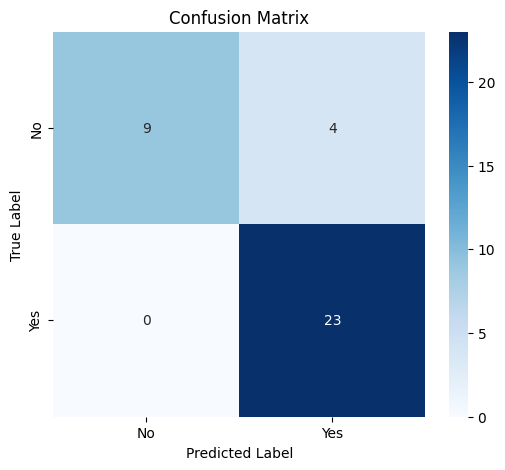

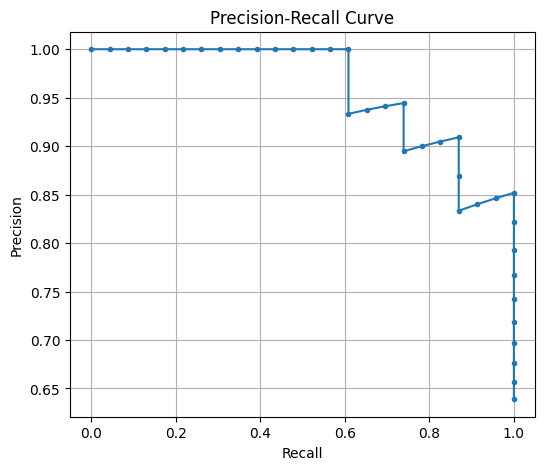


# Calibration Evaluation
Log Loss: 0.4819057163709548
Brier Loss: 0.15198911582256325


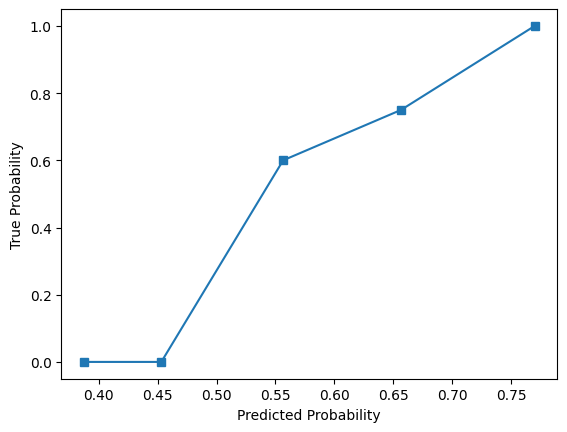

In [17]:
evaluate_model(val_labels, platt_probs)

In [19]:
# Fit isotonic regression
iso_reg = IsotonicRegression(out_of_bounds="clip")  # Clip ensures values remain in valid probability range
iso_reg.fit(cal_probs, cal_labels)

# Get calibrated probabilities
iso_probs = iso_reg.predict(val_probs)

# Base Model Evaluation
Accuracy: 0.8888888888888888
F1 Score: 0.92
Average Precision Score: 0.955915506299138


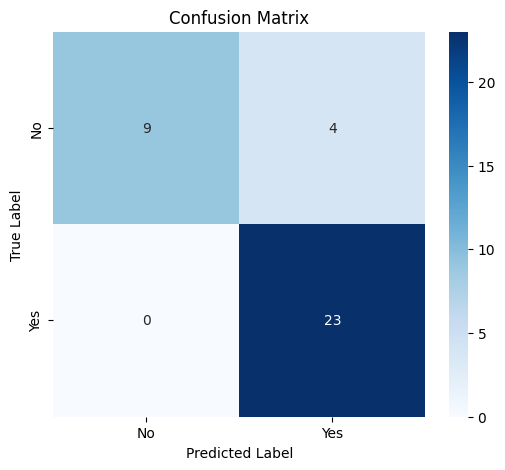

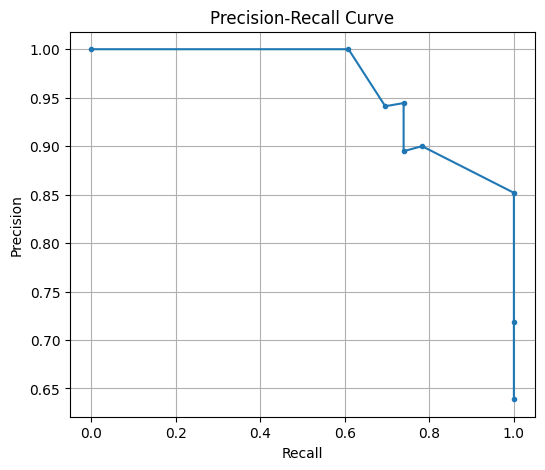


# Calibration Evaluation
Log Loss: 0.264501250383166
Brier Loss: 0.08634770837590006


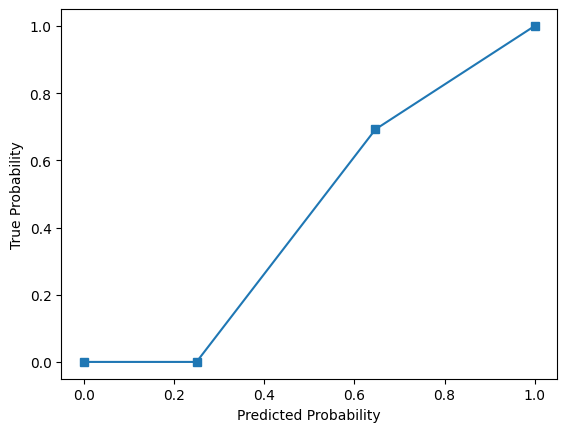

In [20]:
evaluate_model(val_labels, iso_probs)